In [2]:
import sys
sys.path

['',
 'G:\\speech recognition\\VAD-python-master\\VAD-python-master\\pyAudioAnalysis-master\\pyAudioAnalysis-master\\pyAudioAnalysis',
 'G:\\speech recognition\\VAD-python-master\\VAD-python-master',
 'G:\\speech segregation\\gcc-nmf-master\\gcc-nmf-master',
 'G:\\New folder\\python36.zip',
 'G:\\New folder\\DLLs',
 'G:\\New folder\\lib',
 'G:\\New folder',
 'G:\\New folder\\lib\\site-packages',
 'G:\\New folder\\lib\\site-packages\\win32',
 'G:\\New folder\\lib\\site-packages\\win32\\lib',
 'G:\\New folder\\lib\\site-packages\\Pythonwin',
 'G:\\New folder\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Venkatesan R\\.ipython']

In [3]:
from gccNMF.gccNMFFunctions import *
from gccNMF.gccNMFPlotting import *
from gccNMF.wavfile import wavwrite

from numpy import *
from numpy.fft import rfft, irfft
from matplotlib.pylab import cm
from matplotlib import gridspec

from IPython import display

%matplotlib inline

In [16]:
# Preprocessing params
fftSize = 1024

# Asymmetric windowing params
analysisWindowSize = fftSize
synthesisWindowSize = 128
asymmetricHopSize = (synthesisWindowSize * 3) // 4
m = synthesisWindowSize // 2
k = analysisWindowSize
d = 0

# Symmetric windowing params
symmetricWindowSize = fftSize
#symmetricHopSize = (fftSize * 3) // 4
symmetricHopSize = asymmetricHopSize # to better compare results

# TDOA params
numTDOAs = 128
targetTDOAEpsilonPercent = 0.05 # controls the TDOA width for GCC-NMF mask generation
targetTDOAEpsilon = targetTDOAEpsilonPercent * numTDOAs

# NMF params
trainingDataFileName = 'G:\\speech segregation\\gcc-nmf-master\\gcc-nmf-master\\data\\chimeTrainSet.npy'
dictionarySize = 128
numPreLearningIterations = 100
numInferenceIterations = 0
sparsityAlpha = 0
epsilon = 1e-16
seedValue = 0

# Input params    
mixtureFileNamePrefix = 'G:\\speech segregation\\gcc-nmf-master\\gcc-nmf-master\\data\\dev_Sq1_Co_A'
microphoneSeparationInMetres = 0.086

In [26]:
# Input params    
mixtureFileNamePrefix = "G:\\speech segregation\\gcc-nmf-master\\gcc-nmf-master\\data\\dev_Sq1_Co_A"
mixtureFileName = getMixtureFileName(mixtureFileNamePrefix)
mixtureFileName

'G:\\speech segregation\\gcc-nmf-master\\gcc-nmf-master\\data\\dev_Sq1_Co_A_mix.wav'

In [32]:
stereoSamples, sampleRate = loadMixtureSignal(mixtureFileName)
len(stereoSamples) #verify two channel information

2

In [29]:
numChannels, numSamples = stereoSamples.shape
durationInSeconds = numSamples / float(sampleRate)

display.display( display.Audio(mixtureFileName) )

Input mixture signal:
	sampleRate: 16000 samples/sec
	numChannels: 2
	numSamples: 160000
	dtype: float32
	duration: 10.00 seconds


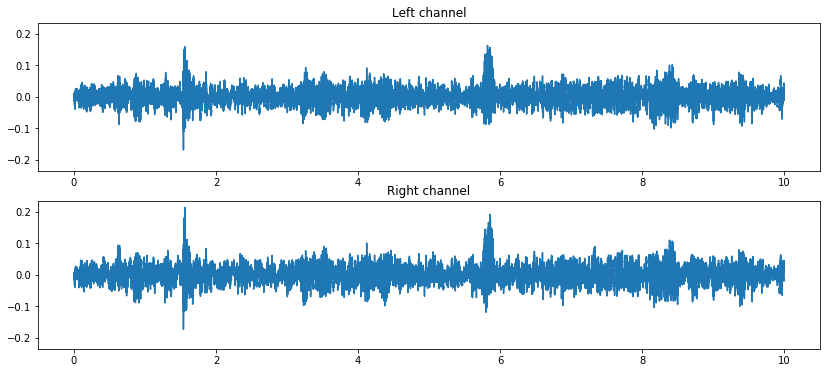

In [30]:
describeMixtureSignal(stereoSamples, sampleRate)

figure(figsize=(14, 6))
plotMixtureSignal(stereoSamples, sampleRate)

In [33]:
trainV = load(trainingDataFileName)
numFrequencies, numTrainFrames = trainV.shape
frequenciesInHz = getFrequenciesInHz(sampleRate, numFrequencies)
frequenciesInkHz = frequenciesInHz / 1000.0

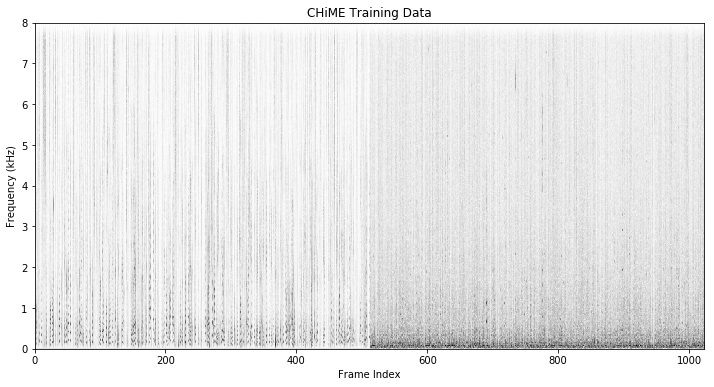

In [34]:
figure(figsize=(12, 6))
imshow((trainV / max(trainV)) ** (1/3.0),
        extent=[0, trainV.shape[1]-1, frequenciesInkHz[0], frequenciesInkHz[-1]],
        cmap=cm.binary)
title('CHiME Training Data')
ylabel('Frequency (kHz)')
xlabel('Frame Index')
show()

In [35]:
W, H = performKLNMF(trainV, dictionarySize, numPreLearningIterations,
                    sparsityAlpha, epsilon, seedValue)

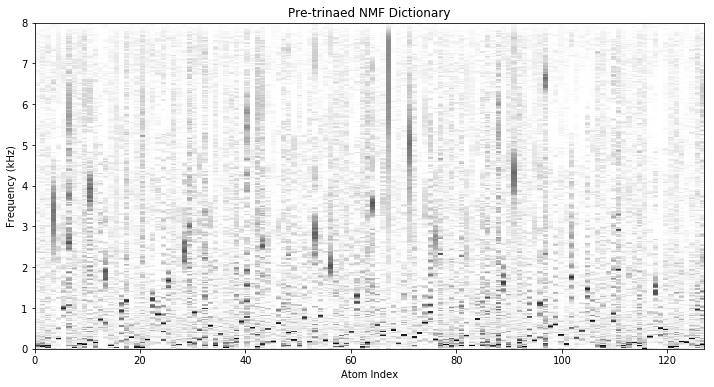

In [36]:
figure(figsize=(12, 6))
imshow((W / max(W)) ** (1/3.0),
        extent=[0, W.shape[1]-1, frequenciesInkHz[0], frequenciesInkHz[-1]],
        cmap=cm.binary)
title('Pre-trinaed NMF Dictionary')
ylabel('Frequency (kHz)')
xlabel('Atom Index')
show()

In [37]:
def getAsymmetricAnalysisWindow(k, m, d):
    risingSqrtHann = sqrt( hanning(2*(k-m-d)+1)[:2*(k-m-d)] )
    fallingSqrtHann = sqrt( hanning(2*m+1)[:2*m] )
    
    window = zeros(k)
    window[:d] = 0
    window[d:k-m] = risingSqrtHann[:k-m-d]
    window[k-m:] = fallingSqrtHann[-m:]
    
    return window

def getAsymmetricSynthesisWindow(k, m, d):
    risingSqrtHannAnalysis = sqrt( hanning(2*(k-m-d)+1)[:2*(k-m-d)] )
    risingNoramlizedHann = hanning(2*m+1)[:m] / risingSqrtHannAnalysis[k-2*m-d:k-m-d]
    fallingSqrtHann = sqrt( hanning(2*m+1)[:2*m] )
    
    window = zeros(k)
    window[:-2*m] = 0
    window[-2*m:-m] = risingNoramlizedHann
    window[-m:] = fallingSqrtHann[-m:]
    
    return window

In [38]:
analysisWindow = getAsymmetricAnalysisWindow(k, m, d)
synthesisWindow = getAsymmetricSynthesisWindow(k, m, d)

symmetricWindow = sqrt(hanning(symmetricWindowSize))

In [39]:
tdoasInSeconds = getTDOAsInSeconds(microphoneSeparationInMetres, numTDOAs)
expJOmegaTau = exp( outer(frequenciesInHz, -(2j * pi) * tdoasInSeconds) )

In [40]:
def performOnlineSpeechEnhancement(analysisWindow, synthesisWindow, hopSize):
    # Setup variables to save speech enhancement results
    numFrames = (numSamples-len(synthesisWindow)) // hopSize
    gainFactor = hopSize / float(len(synthesisWindow)) * 2

    targetEstimateSamplesOLA = zeros_like(stereoSamples)
    gccPHATAccumulatedMax = zeros(numTDOAs)
    gccPHATAccumulatedMax[:] = -inf
    atomMask = zeros(dictionarySize)
    targetTDOAs = zeros(numFrames)
    targetTDOAs[:] = nan

    angularSpectrogram = zeros( (numTDOAs, numFrames) )
    atomMasks = zeros( (dictionarySize, numFrames) )
    wienerFilters = zeros( (2, numFrequencies, numFrames) )
    inputSpectrogram = zeros( (2, numFrequencies, numFrames), 'complex64')
    outputSpectrogram = zeros( (2, numFrequencies, numFrames), 'complex64')

    # For each STFT frame:
    # 1. Compute FFT
    # 2. Localize target with accumulated GCC-PHAT localization
    # 3. Compute GCC-NMF atom mask
    # 4. Construct Wiener-like filter, and filter input
    # 5. Reconstruct time domain samples
    # 6. Overlap-add to output samples
    
    for frameIndex in range(numFrames):
        # Compute FFT
        frameStart = frameIndex * hopSize
        frameEnd = frameStart + analysisWindowSize
        stereoSTFTFrame = rfft( stereoSamples[:, frameStart:frameEnd] * analysisWindow )
        inputSpectrogram[..., frameIndex] = stereoSTFTFrame

        # localize target with accumulated GCC-PHAT
        coherenceV = stereoSTFTFrame[0] * stereoSTFTFrame[1].conj() / abs(stereoSTFTFrame[0]) / abs(stereoSTFTFrame[1])
        gccPHAT = dot(coherenceV, expJOmegaTau).real
        gccPHATAccumulatedMax = max( array( [gccPHAT, gccPHATAccumulatedMax] ), axis=0 )
        targetTDOAEstimate = argmax(gccPHATAccumulatedMax)
        targetTDOAs[frameIndex] = targetTDOAEstimate
        angularSpectrogram[:, frameIndex] = gccPHAT

        # compute GCC-NMF atom mask
        gccNMF = dot( (coherenceV[:, newaxis] * expJOmegaTau).real.T, W )
        gccNMFTDOAEstimates = argmax(gccNMF, axis=0)
        atomMask[:] = 0
        atomMask[ abs(gccNMFTDOAEstimates - targetTDOAEstimate) < targetTDOAEpsilon ] = 1
        atomMasks[:, frameIndex] = atomMask

        # construct wiener filter
        if numInferenceIterations == 0:
            wienerFilter = sum(atomMask * W, axis=1) / sum(W, axis=1)
            wienerFilters[:, :, frameIndex] = wienerFilter
        else:
            stereoH = inferCoefficientsKLNMF( abs(stereoSTFTFrame).T, W, numInferenceIterations,
                                              sparsityAlpha, epsilon, seedValue)
            recV = dot(W, stereoH)
            sourceEstimate = dot(W, stereoH * atomMask[:, newaxis])
            wienerFilter = (sourceEstimate / recV).T
            wienerFilters[:, :, frameIndex] = wienerFilter

        filterdSTFTFrame = wienerFilter * stereoSTFTFrame
        outputSpectrogram[..., frameIndex] = filterdSTFTFrame

        # reconstruct time domain samples
        recStereoSTFTFrame = irfft(filterdSTFTFrame)

        # overlap-add to output samples
        targetEstimateSamplesOLA[:, frameStart:frameEnd] += recStereoSTFTFrame

    targetEstimateSamplesOLA *= gainFactor
        
    return inputSpectrogram, outputSpectrogram, targetEstimateSamplesOLA, \
           gccPHATAccumulatedMax, targetTDOAs, angularSpectrogram, atomMasks, wienerFilters

In [41]:
def plotResults(titleString, mainGridSpec, inputSpectrogram, outputSpectrogram, targetEstimateSamplesOLA, \
                gccPHATAccumulatedMax, targetTDOAs, angularSpectrogram, atomMasks, wienerFilters):
    gridSpec = gridspec.GridSpecFromSubplotSpec(5, 1, mainGridSpec)
    ax = subplot(gridSpec[0])
    imshow(angularSpectrogram, cmap=cm.jet,
           extent=[0, angularSpectrogram.shape[1]-1, tdoasInSeconds[0]*1000.0, tdoasInSeconds[-1]*1000.0])
    targetTDOAsInMilliSeconds = take(tdoasInSeconds, targetTDOAs.astype('int32')) * 1000.0
    plot( targetTDOAsInMilliSeconds, 'r')
    ylabel('TDOA (ms)')
    title(titleString)
    
    ax = subplot(gridSpec[1])
    imshow( atomMasks, cmap=cm.binary )
    ylabel('Atom Index')
    
    ax = subplot(gridSpec[2])
    imshow( wienerFilters[0], cmap=cm.jet,
            extent=[0, wienerFilters.shape[-1]-1, frequenciesInkHz[0], frequenciesInkHz[-1]] )
    ylabel('Frequency (kHz)')
                    
    ax = subplot(gridSpec[3])
    imshow( abs(outputSpectrogram[0]) ** (1/3.0), cmap=cm.jet,
            extent=[0, outputSpectrogram.shape[-1]-1, frequenciesInkHz[0], frequenciesInkHz[-1]] )
    ylabel('Frequency (kHz)')
    
    ax = subplot(gridSpec[4])
    plot(targetEstimateSamplesOLA[0])
    xlim( (0, targetEstimateSamplesOLA.shape[-1]-1) )
    xlabel('Time (samples)')

In [47]:
symmetricResults = performOnlineSpeechEnhancement(symmetricWindow, symmetricWindow, symmetricHopSize)
asymmetricResults = performOnlineSpeechEnhancement(analysisWindow, synthesisWindow, asymmetricHopSize)


(array([[[ 1.4838582e+00+0.00000000e+00j,  2.5759938e+00+0.00000000e+00j,
           2.7798266e+00+0.00000000e+00j, ...,
          -4.0649626e-01+0.00000000e+00j, -1.0934372e+00+0.00000000e+00j,
          -1.0983056e+00+0.00000000e+00j],
         [-2.6758125e+00+1.94681680e+00j, -2.4994323e+00+2.02221185e-01j,
          -1.9289583e+00-9.44406390e-01j, ...,
          -7.5102439e+00+1.15732253e+00j, -6.1351147e+00-5.64812422e+00j,
           6.2604439e-01-8.64693642e+00j],
         [ 2.3339920e+00+1.79133725e+00j, -5.6506437e-01+2.14066935e+00j,
          -1.5700806e+00-3.56514990e-01j, ...,
           1.0928845e+01-5.88059807e+00j,  1.0685874e+01+7.21697521e+00j,
          -1.2740209e+00+1.28164406e+01j],
         ...,
         [ 1.8236091e-02+1.48325125e-02j,  2.2366887e-02-8.43139086e-03j,
           2.7086050e-03-2.08747573e-02j, ...,
          -1.8113768e-02+4.66324389e-03j,  6.2061651e-03+1.50266364e-02j,
           1.3675093e-02-1.31911915e-02j],
         [-2.2144321e-02-7.4553587

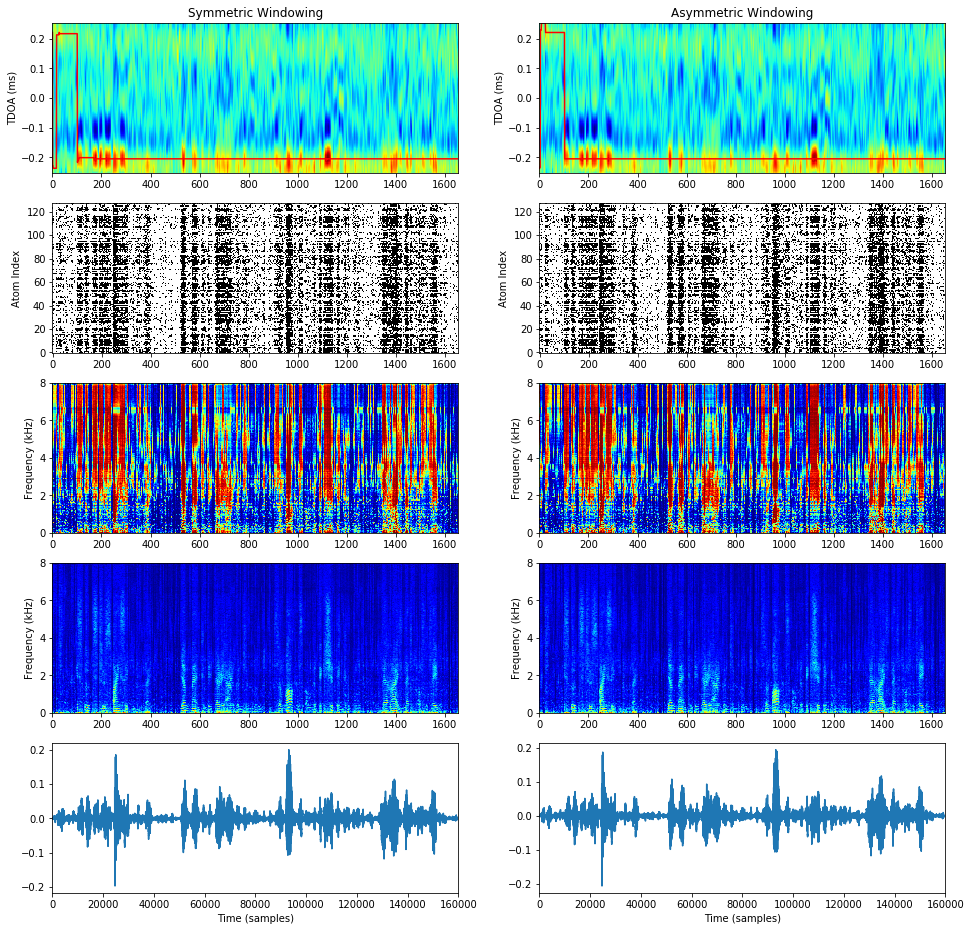

In [43]:
figure(figsize=(16, 16))
mainGridSpec = gridspec.GridSpec(1, 2)
plotResults( 'Symmetric Windowing', mainGridSpec[0], *symmetricResults)
plotResults( 'Asymmetric Windowing', mainGridSpec[1], *asymmetricResults )
show()

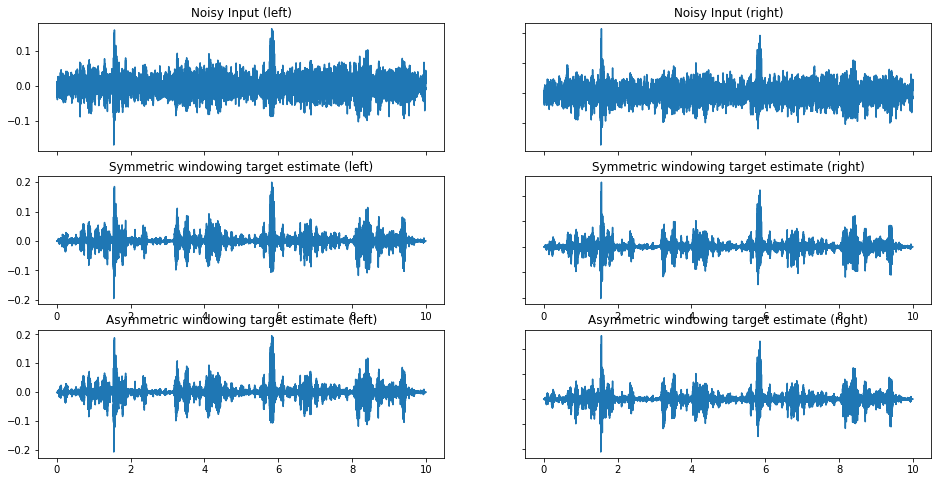

In [44]:
figure(figsize=(16, 8))

sampleTimesInSeconds = arange(numSamples) / float(sampleRate)

ax = subplot(321)
plot(sampleTimesInSeconds, stereoSamples[0])
ax.set_xticklabels([])
title('Noisy Input (left)')

ax = subplot(322)
plot(sampleTimesInSeconds, stereoSamples[1])
ax.set_xticklabels([])
ax.set_yticklabels([])
title('Noisy Input (right)')

ax = subplot(323)
plot(sampleTimesInSeconds, symmetricResults[2][0])
title('Symmetric windowing target estimate (left)')

ax = subplot(324)
plot(sampleTimesInSeconds, symmetricResults[2][1])
ax.set_yticklabels([])
title('Symmetric windowing target estimate (right)')

ax = subplot(325)
plot(sampleTimesInSeconds, asymmetricResults[2][0])
title('Asymmetric windowing target estimate (left)')

ax = subplot(326)
plot(sampleTimesInSeconds, asymmetricResults[2][1])
ax.set_yticklabels([])
title('Asymmetric windowing target estimate (right)')

show()

In [56]:


print('Noisy Mixture:')
display.display(display.Audio(mixtureFileName))



Noisy Mixture:


In [53]:
symmetricTargetEstimateFileName = mixtureFileNamePrefix + '_sim_symmetric.wav'
wavwrite(symmetricResults[2], symmetricTargetEstimateFileName, sampleRate)
symmetricTargetEstimateFileName

'G:\\speech segregation\\gcc-nmf-master\\gcc-nmf-master\\data\\dev_Sq1_Co_A_sim_symmetric.wav'

In [55]:
print('Symmetric Target Estimate:')
display.display(display.Audio(symmetricTargetEstimateFileName))

Symmetric Target Estimate:


In [59]:
asymmetricTargetEstimateFileName = mixtureFileNamePrefix + '_sim_asymmetric.wav'
wavwrite(asymmetricResults[2], asymmetricTargetEstimateFileName, sampleRate)

In [60]:
print('Asymmetric Target Estimate:')
display.display(display.Audio(asymmetricTargetEstimateFileName))

Asymmetric Target Estimate:
